In [1]:
try:
  import optax
except:
  %pip install -qq optax
  import optax
try:
    from ajax import Prior, Likelihood, Variational, ADVI
except:
   %pip install -qq git+https://github.com/patel-zeel/ajax.git
   from ajax import Prior, Likelihood, Variational, ADVI

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns
from ajax.utils import fill_params
import jax
import matplotlib.pyplot as plt
import pickle
import pandas as pd
tfd = tfp.distributions
tfb = tfp.bijectors
import seaborn as sns

In [2]:
with open("../data/linear_regression_normal_distribution",'rb') as f:
    data = pickle.load(f)
data

{'data': {'x': array([[-1.4144772 ],
         [ 1.6039085 ],
         [ 2.293806  ],
         [ 3.8276772 ],
         [ 1.999692  ],
         [ 1.0609426 ],
         [ 1.2900534 ],
         [-2.3558607 ],
         [ 3.0193057 ],
         [-0.89879274]], dtype=float32),
  'y': array([ 1.2143412,  7.422146 , 10.44427  , 12.321105 ,  7.133485 ,
          6.848776 ,  6.8407617, -1.5791223, 11.820506 ,  1.6998756],
        dtype=float32)},
 'noise_variance': 1,
 'prior': {'mean': array([14. ,  7.3], dtype=float32),
  'var': array([[10.,  0.],
         [ 0., 10.]], dtype=float32)}}

In [3]:
X = data['data']['x']
Y = data['data']['y']

def identity_trans(x):
    return jnp.append(jnp.ones((m,1)),x,axis=1)
m = X.shape[0]
X = identity_trans(X)
mean_prior = data['prior']['mean']
var_prior = data['prior']['var']
prior = Prior(
    distributions = {
        "theta" : tfp.distributions.MultivariateNormalDiag(loc = mean_prior, scale_diag = jnp.diagonal(var_prior))
        }
    )

In [4]:
def link_func(samples):
    mean = X@samples["theta"]
    diag = jnp.ones_like(mean)
    return {"loc" : mean, "scale_diag" : diag}

In [5]:
likelihood = Likelihood(tfp.distributions.MultivariateNormalDiag, link_func)

In [6]:
variational = Variational(
    prior=prior,
    bijectors={"theta":tfb.Identity()},
    vi_type="full_rank"
)

In [7]:
advi = ADVI(prior, likelihood, variational, Y)
Y.shape

(10,)

In [8]:
params = variational.get_params()
tx = optax.adam(learning_rate=0.1)
state = tx.init(params)
value_and_grad_fun = jax.jit(jax.value_and_grad(advi.loss))

In [9]:
def update_func(carry,x):
  params = carry['params']
  state = carry['state']
  seed = carry['seed']
  seed = jax.random.split(seed, 1)[0]
  loss, grads = value_and_grad_fun(params, seed = seed)
  updates, state = tx.update(grads, state)
  params = optax.apply_updates(params, updates)
  carry = {'params':params, 'state':state, 'seed':seed}
  return carry, loss

In [10]:
carry = {'params':params, 'state': state,'seed':jax.random.PRNGKey(100)}
carry,loss = jax.lax.scan(update_func, carry,xs = None,length= 350) 
loss

DeviceArray([724.18286 , 258.6554  , 493.9683  , 101.28939 , 294.82098 ,
             349.52515 ,  67.81837 , 207.18268 , 147.9197  , 278.1618  ,
             254.59666 , 227.93672 , 127.90262 ,  84.82995 ,  69.22429 ,
             212.09512 , 102.186615,  70.9604  , 197.90434 , 118.22158 ,
              59.393616,  96.6113  ,  16.65726 ,  81.32517 ,  36.519783,
              60.526978,  18.717678,  30.542679,  29.722649,  38.318916,
              38.73203 ,  27.531479,  23.46746 ,  21.155405,  26.608809,
              29.531902,  20.831917,  21.830654,  31.651226,  24.295326,
              21.48712 ,  23.412714,  22.466381,  24.752155,  20.941753,
              24.054907,  28.063107,  20.195696,  23.932518,  24.307285,
              25.096727,  21.391354,  24.404293,  25.01939 ,  32.068638,
              24.526754,  20.970009,  20.720352,  25.46098 ,  20.028538,
              23.329477,  22.533787,  19.42607 ,  21.45922 ,  23.171211,
              21.29714 ,  21.420698,  19.154804,  2

In [11]:
likelihood.log_prob(data=Y,params =prior.sample(seed = jax.random.PRNGKey(100)))

DeviceArray(-4599.714, dtype=float32)

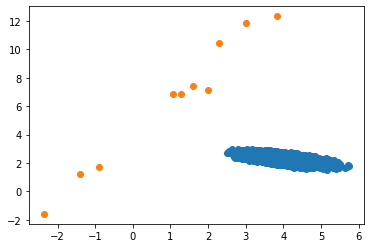

In [12]:
x = jnp.linspace(1,6,10000)
variational.set_params(carry['params'])
di = {"theta":x}
samples = variational.sample(seed = jax.random.PRNGKey(10),sample_shape = (100000,))
plt.scatter(samples['theta'][:,0],samples['theta'][:,1])
plt.scatter(data['data']['x'],data['data']['y'])

In [13]:
def posterior(phi,m_0, t, S_0, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = jnp.linalg.inv(S_0) + beta * phi.T.dot(phi)
    S_N = jnp.linalg.inv(S_N_inv)
    m_N =S_N@(jnp.linalg.inv(S_0)@m_0+beta *phi.T.dot(t))

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N


In [14]:
mean,cov = posterior(X, mean_prior, Y, var_prior,1)


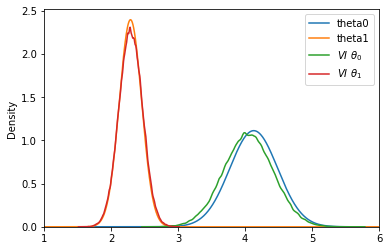

In [15]:
plt.xlim(1,6)
normal1 = tfd.Normal(mean[0],jnp.sqrt(cov[0,0]))
x = jnp.linspace(1,6,10000)
pdf1 = normal1.prob(x)
plt.plot(x,pdf1,label="theta0")
normal2 = tfd.Normal(mean[1],jnp.sqrt(cov[1,1]))
pdf2=  normal2.prob(x)
plt.plot(x,pdf2,label="theta1")
sns.kdeplot(samples["theta"][:,0],label=r"$VI\ \theta_0$",bw_method= 0.05)
sns.kdeplot(samples["theta"][:,1],label = r"$VI\ \theta_1$",bw_method = 0.05)
plt.legend()
plt.savefig("ajax_linear_regression")

In [16]:
with open("./linear_regression_Ajax",'wb') as f:
    pickle.dump(variational, f,protocol = 1)